In [258]:
from data_utils import CustomImageDataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [259]:
plt.style.use("ggplot")

In [260]:
class MyModel(nn.Module):
    def __init__(self, latent_dim=32, dropout=0.15, input_c=3) -> None:
        super().__init__()
        self.input_c = input_c
        self.criterion = nn.MSELoss()

        self.Encoder = nn.Sequential(
            nn.Conv2d(input_c, 6, 3, stride=2, padding=1), # 14x14
            nn.ReLU(),
            # nn.Conv2d(8, 8, 3, stride=2, padding=1), # 7x7
            # nn.ReLU(),
            # nn.MaxPool2d(3, stride=2, padding=1), # 7x7
        )
        self.fc1 = nn.Linear(6*14*14, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_log_var = nn.Linear(512, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 6*14*14)

        self.Decoder = nn.Sequential(
            nn.Linear(6*14*14, input_c*28*28),
            nn.Sigmoid(),
        )

    def encoder(self, x):
        return self.Encoder(x)
    
    def decoder(self, x):
        return self.Decoder(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def loss(self, reconstruction, x):
        return ((reconstruction - x)**2).sum()
 
    def forward(self, x):
        # encoding
        encoded = self.encoder(x)
        hidden = torch.flatten(encoded, 1)

        hidden = self.fc1(hidden)
        hidden = F.relu(hidden)

        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        z = self.fc2(z)
        z = F.relu(z)

        z = z.view(-1, 6, 14, 14)

        z = torch.flatten(z, 1)
 
        # decoding
        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view((-1, self.input_c, 28, 28))

        return reconstruction, mu, log_var

In [261]:
torch.manual_seed(0)

In [262]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [263]:
batch_size = 128

In [264]:
# transform = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0), std=(1)),
#      transforms.Resize((28, 28)),
#      transforms.RandomAdjustSharpness(9, p=1),
#      transforms.Grayscale(1),
#      ])
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0), std=(1)),
     transforms.RandomAdjustSharpness(5, p=1),
     transforms.Resize((28, 48)),
     transforms.CenterCrop((28, 28)),
     transforms.GaussianBlur(3),
     ])

In [265]:
train_data_path = "./homework_2_dataset/dataset/train"
train_dataset = CustomImageDataset(os.path.join(train_data_path, "annotation.txt"), os.path.join(train_data_path, "imgs"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [266]:
proliv_data_path = "./homework_2_dataset/dataset/proliv"
proliv_dataset = CustomImageDataset(os.path.join(proliv_data_path, "annotation.txt"), os.path.join(proliv_data_path, "imgs"), transform=transform)
proliv_dataloader = DataLoader(proliv_dataset, batch_size=batch_size, shuffle=True)

In [267]:
test_data_path = "./homework_2_dataset/dataset/test"
test_dataset = CustomImageDataset(os.path.join(test_data_path, "annotation.txt"), os.path.join(test_data_path, "imgs"), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [268]:
model = MyModel(input_c=3).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(12)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device) # GPU
        opt.zero_grad()
        reconstruction, _, _ = model(x)
        loss = model.loss(reconstruction, x)
        running_loss += loss / batch_size
        loss.backward()
        opt.step()
    
    model.eval()
    val_count = 0
    val_loss = 0   
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device) # GPU
            reconstruction, _, _ = model(x)
            loss = model.loss(reconstruction, x)
            val_loss += loss / batch_size
    print(f"epoch {epoch}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}")

  0%|          | 0/12 [00:00<?, ?it/s]

e:\2023_processing_and_generating_images_course_homeworks\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  8%|▊         | 1/12 [00:11<02:10, 11.84s/it]

epoch 0: train loss 5.852899551391602, validation loss 15.351829528808594


 17%|█▋        | 2/12 [00:23<02:00, 12.02s/it]

epoch 1: train loss 3.27339768409729, validation loss 14.385494232177734


 25%|██▌       | 3/12 [00:35<01:47, 11.92s/it]

epoch 2: train loss 2.525301456451416, validation loss 13.979569435119629


 33%|███▎      | 4/12 [00:47<01:35, 11.96s/it]

epoch 3: train loss 2.1726245880126953, validation loss 12.22163200378418


 42%|████▏     | 5/12 [00:59<01:23, 11.93s/it]

epoch 4: train loss 1.783233880996704, validation loss 12.12025260925293


 50%|█████     | 6/12 [01:11<01:11, 11.94s/it]

epoch 5: train loss 1.6100828647613525, validation loss 11.706855773925781


 58%|█████▊    | 7/12 [01:23<00:59, 12.00s/it]

epoch 6: train loss 1.4606637954711914, validation loss 11.189325332641602


 67%|██████▋   | 8/12 [01:35<00:47, 11.99s/it]

epoch 7: train loss 1.3215854167938232, validation loss 11.454132080078125


 75%|███████▌  | 9/12 [01:48<00:36, 12.23s/it]

epoch 8: train loss 1.2239679098129272, validation loss 11.220440864562988


 83%|████████▎ | 10/12 [02:00<00:24, 12.31s/it]

epoch 9: train loss 1.2100712060928345, validation loss 11.451695442199707


 92%|█████████▏| 11/12 [02:14<00:12, 12.60s/it]

epoch 10: train loss 1.0711833238601685, validation loss 10.973811149597168


100%|██████████| 12/12 [02:28<00:00, 12.36s/it]

epoch 11: train loss 1.0184966325759888, validation loss 10.925008773803711


In [298]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction, _, _ = model(x)
        loss = model.loss(reconstruction, x)
        losses.append(loss.item())

thresolds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)

        # print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}")

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 5.653000000000001


In [299]:

tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:

    x = x.to(device) # GPU
    reconstruction, _, _ = model(x)
    loss = model.loss(reconstruction, x)

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0
    
    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1
    
tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(f"True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}, Threshold: {np.quantile(best_tresholds, 0.9)}")

True Positive Rate: 0.938, True Negative Rate: 0.941, Threshold: 5.653000000000001


In [300]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction, _, _ = model(x)
        loss = model.loss(reconstruction, x)
        losses.append(loss.item())

thresolds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 1000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.3f}, True Negative Rate: {(tn / (tn + fp)):.3f}")

threshold = 4.87: True Positive Rate: 0.961, True Negative Rate: 0.911
threshold = 4.88: True Positive Rate: 0.961, True Negative Rate: 0.912
threshold = 4.89: True Positive Rate: 0.961, True Negative Rate: 0.912
threshold = 4.90: True Positive Rate: 0.961, True Negative Rate: 0.913
threshold = 4.91: True Positive Rate: 0.961, True Negative Rate: 0.914
threshold = 4.92: True Positive Rate: 0.961, True Negative Rate: 0.914
threshold = 4.93: True Positive Rate: 0.953, True Negative Rate: 0.915
threshold = 4.94: True Positive Rate: 0.953, True Negative Rate: 0.915
threshold = 4.95: True Positive Rate: 0.953, True Negative Rate: 0.915
threshold = 4.96: True Positive Rate: 0.953, True Negative Rate: 0.915
threshold = 4.97: True Positive Rate: 0.953, True Negative Rate: 0.917
threshold = 4.98: True Positive Rate: 0.953, True Negative Rate: 0.917
threshold = 4.99: True Positive Rate: 0.953, True Negative Rate: 0.918
threshold = 5.00: True Positive Rate: 0.953, True Negative Rate: 0.918
thresh

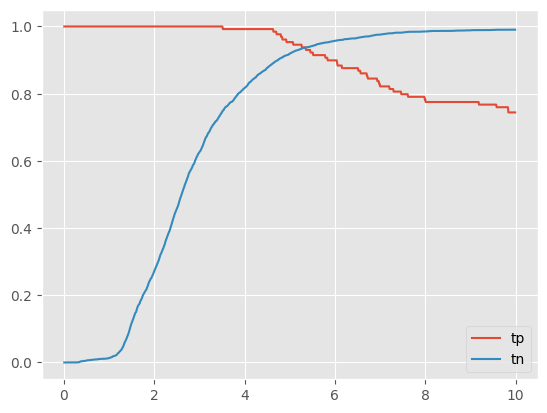

In [301]:
plt.plot(thresolds, tp_rate, label="tp")
plt.plot(thresolds, tn_rate, label="tn")
plt.legend() 
plt.show()

In [302]:
torch.save(model.state_dict(), "./autoencoders/MyModel")